# Exploratory Analysis VEOLIA

In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random

In [9]:
data=pd.read_csv("train.csv")
target=pd.read_csv("train_label.csv",delimiter=";")
data.drop("Id",axis=1,inplace=True)
target.drop("Id",axis=1,inplace=True)

## First Look

In [10]:
data.head(3)

,Feature1,Feature2,Feature3,Feature4,Length,YearConstruction,YearLastFailureObserved
0,T,IAB,-0.209841,C,3.5972,2001,NaN
1,T,U,2.184992,M,4.0547,1965,NaN
2,P,U,-0.434356,D,3.9669,2003,NaN


In [11]:
target.head(3)

,2014,2015
0,0,0
1,0,0
2,0,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19427 entries, 0 to 19426
Data columns (total 7 columns):
Feature1                   19427 non-null object
Feature2                   19427 non-null object
Feature3                   19427 non-null float64
Feature4                   19427 non-null object
Length                     19427 non-null float64
YearConstruction           19427 non-null int64
YearLastFailureObserved    290 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 1.0+ MB


In [13]:
print("Failures in 2014:" ,np.sum(target["2014"]),"({:.2%} of the pipes)".format(np.sum(target["2014"])/len(target)))
print("Failures in 2015:" ,np.sum(target["2015"]),"({:.2%} of the pipes)".format(np.sum(target["2015"])/len(target)))

Failures in 2014: 53 (0.27% of the pipes)
Failures in 2015: 37 (0.19% of the pipes)


## Missing Values

We clearly are in a context of anomaly detection since the label 1 representing failures is minoritary.
What does the NaN values in "YearLastFailureObserved" mean ? 
I see two possibilities:


1. Veolia does not have the information (highly improbable)
2. NaN represents the event {no failures occured since the construction of the pipe}. (most likely)


Can we try to confirm hypothesis 2?

I will try to seperate my data in two categories:
- Pipes that break in 2014 or 2015
- Pipes that don't break in 2014 or 2015

Then I will compare the percentage of NaN for the feature "YearLastFailureObserved" for the two categories.
The main idea behind all this is that if a pipe has already broken, the chance that he will break again is higher.
So we should find less NaN in already failed pipes.

In [14]:
#get index of failed pipes:
index_fail=target.index[(target["2014"]==1) | (target["2015"]==1)].tolist()

#get index of safe pipes:
index_safe=[x for x in target.index.tolist() if x not in index_fail]

In [15]:
#get proportion of NaN within the two categories:

#Estimation of NaN proportion in safe pipes by subsampling 
niter=1000
temp=list(range(niter))
for i in range(niter):
    index_safe_sample=random.sample(index_safe, len(index_fail))
    data_safe_sample=data.loc[index_safe_sample]
    temp[i]=(data_safe_sample["YearLastFailureObserved"].isnull().sum()/len(data_safe_sample))
    #we calculate the standard deviation

safenan_estimate=np.mean(temp)
safenan_sd=np.std(temp)    


#Proportion of NaN in already failed pipes
data_fail=data.loc[index_fail]
failnan=data_fail["YearLastFailureObserved"].isnull().sum()/len(data_fail)

print("Proportion of NaN in Safe Pipes: {:.1%} with a standard deviation of {:.4%}".format(safenan_estimate,safenan_sd))
print("Proportion of NaN in Failed Pipes: {:.1%}".format(failnan))

Proportion of NaN in Safe Pipes: 98.6% with a standard deviation of 1.1745%
Proportion of NaN in Failed Pipes: 71.3%


Indeed, the proportion of NaN in Failed Pipes looks smaller. We will check later with feature importance.
This results will encourage us to create a feature "AlreadyFailedPipes" that will seperate pipes that never failed and the others.

## YearConstruction

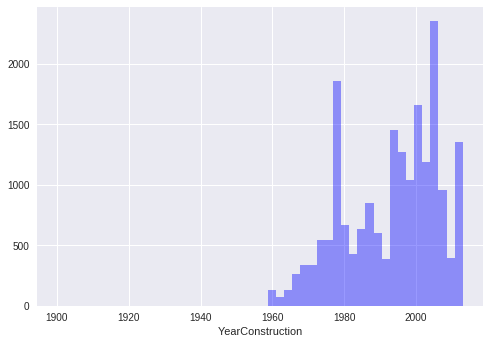

In [16]:
sns.set(color_codes=True)
sns.distplot(data["YearConstruction"],kde=False,color="blue")
plt.show()

Distribution of YearConstruction within target values 

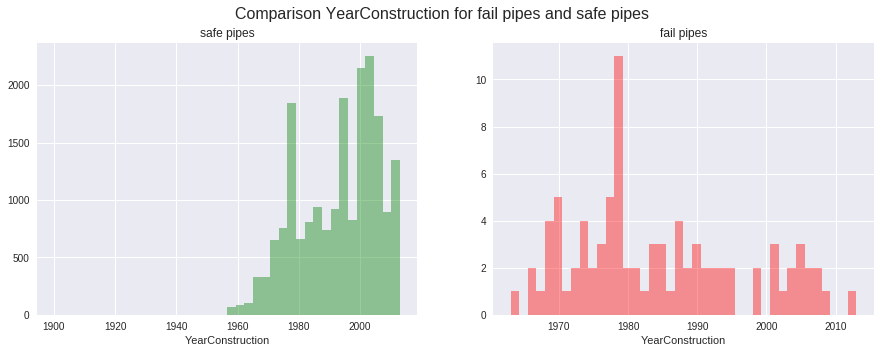

In [17]:
fig, ax=plt.subplots(1,2,figsize=(15,5))
sns.distplot(data["YearConstruction"].loc[index_safe],kde=False,color="green",ax=ax[0],bins=40)
sns.distplot(data["YearConstruction"].loc[index_fail],kde=False,color="red",ax=ax[1],bins=40)

fig.suptitle("Comparison YearConstruction for fail pipes and safe pipes", fontsize=16)
ax[0].set_title("safe pipes")
ax[1].set_title("fail pipes")
plt.show()

/media/adri/Data/adrien/Linux_Programs/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


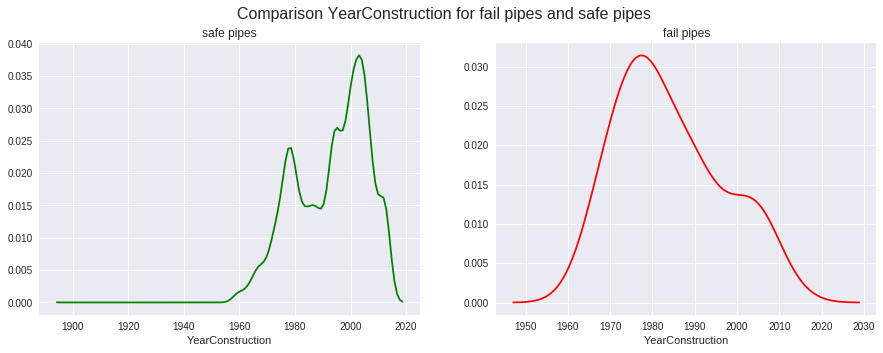

In [18]:
#we can use kernel density estimation to estimate the densities.
fig, ax=plt.subplots(1,2,figsize=(15,5))
sns.distplot(data["YearConstruction"].loc[index_safe],kde=True,hist=False,color="green",ax=ax[0],bins=40)
sns.distplot(data["YearConstruction"].loc[index_fail],kde=True,hist=False,color="red",ax=ax[1],bins=40)

fig.suptitle("Comparison YearConstruction for fail pipes and safe pipes", fontsize=16)
ax[0].set_title("safe pipes")
ax[1].set_title("fail pipes")
plt.show()

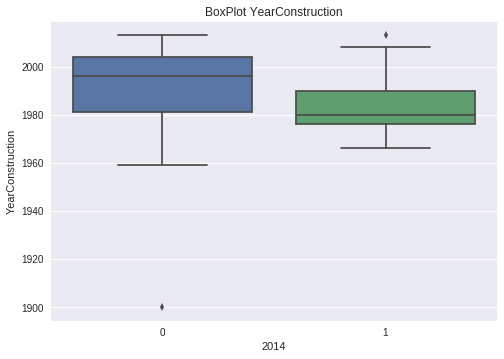

In [19]:
sns.boxplot(x=target["2014"], y=data["YearConstruction"]).set_title("BoxPlot YearConstruction");
plt.show()

It looks like there is a pick of construction right before 1980. Failed pipes tend to be older in comparaison to safe pipes distribution. But we don't really have enough failed pipes to validate this hypothesis.

## Length

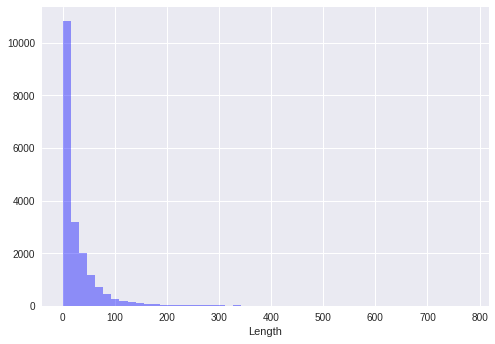

In [20]:
sns.distplot(data["Length"],kde=False,color="blue",bins=50)
plt.show()

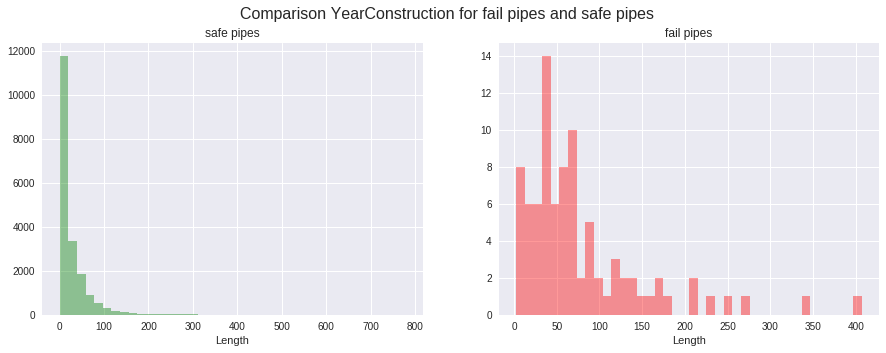

In [21]:
fig, ax=plt.subplots(1,2,figsize=(15,5))
sns.distplot(data["Length"].loc[index_safe],kde=False,color="green",ax=ax[0],bins=40)
sns.distplot(data["Length"].loc[index_fail],kde=False,color="red",ax=ax[1],bins=40)

fig.suptitle("Comparison YearConstruction for fail pipes and safe pipes", fontsize=16)
ax[0].set_title("safe pipes")
ax[1].set_title("fail pipes")
plt.show()

/media/adri/Data/adrien/Linux_Programs/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


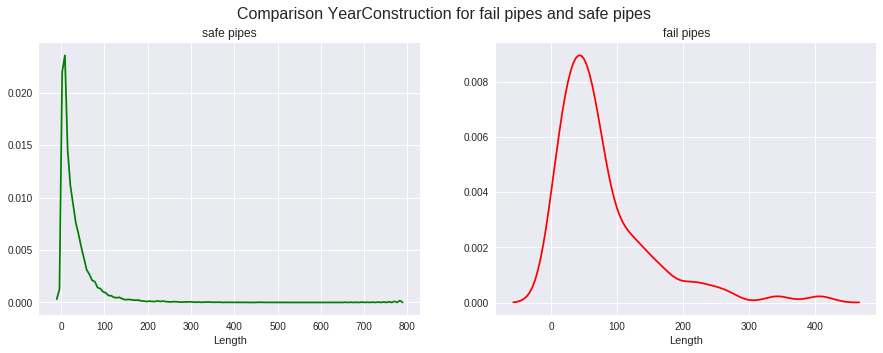

In [22]:
#we can use kernel density estimation to estimate the densities.
fig, ax=plt.subplots(1,2,figsize=(15,5))
sns.distplot(data["Length"].loc[index_safe],kde=True,hist=False,color="green",ax=ax[0],bins=40)
sns.distplot(data["Length"].loc[index_fail],kde=True,hist=False,color="red",ax=ax[1],bins=40)

fig.suptitle("Comparison YearConstruction for fail pipes and safe pipes", fontsize=16)
ax[0].set_title("safe pipes")
ax[1].set_title("fail pipes")
plt.show()

We could have thought that length of the pipes would have different distributions for fail and safe pipes. With the idea that fail pipes may be longer. But the graphics doesn't necessarely validate this hypothesis.

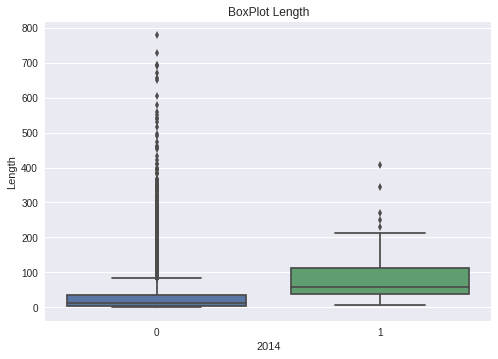

In [23]:
year="2014"
sns.boxplot(x=target[year], y=data["Length"]).set_title("BoxPlot Length");
plt.show()

The difference is not that significant considering the low amount of data for anomalies.

## YearLastFailureObserved

A good idea would be to create a new feature Called TimeSinceLastFailure that would describe the time spent for already failed pipes. Intuitively, a pipe that already failed has a higher probabibility to fail again (maybe due to geographical position, e.g war zone, or design flaw). Moreover, this probability may increase over time. We could get more insights with it.

In [24]:
#construction of the new feature TimeToFailure

df_time=pd.DataFrame(data["YearLastFailureObserved"]-data["YearConstruction"],columns=["TimeToFailure"])

data=pd.concat([data,df_time],axis=1)

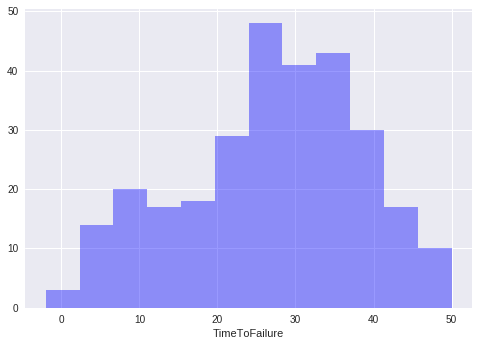

In [25]:
sns.distplot(data["TimeToFailure"].dropna(),kde=False,color="blue")
plt.show()

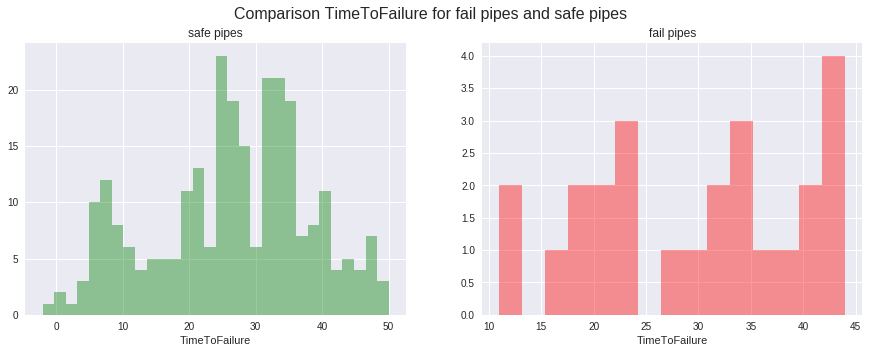

In [26]:
fig, ax=plt.subplots(1,2,figsize=(15,5))
sns.distplot(data["TimeToFailure"].loc[index_safe].dropna(),kde=False,color="green",ax=ax[0],bins=30)
sns.distplot(data["TimeToFailure"].loc[index_fail].dropna(),kde=False,color="red",ax=ax[1],bins=15)

fig.suptitle("Comparison TimeToFailure for fail pipes and safe pipes", fontsize=16)
ax[0].set_title("safe pipes")
ax[1].set_title("fail pipes")
plt.show()

In [27]:
print("There are {} that already failed and that will fail again in 2014 or 2015.".format(len(data["TimeToFailure"].loc[index_fail].dropna())))
print("It means that {:.1%} of the failed pipes in 2014 or 2015 already failed once (at least).".format(25/87))

There are 25 that already failed and that will fail again in 2014 or 2015.
It means that 28.7% of the failed pipes in 2014 or 2015 already failed once (at least).


Seems like we can confirm that pipe that already failed have a higher probability to fail again in the next two years.

## Features 1, 2,3 and 4: Categorical Features

We don't have any information about the meaning of this features except that they are characteristic features of the pipes.

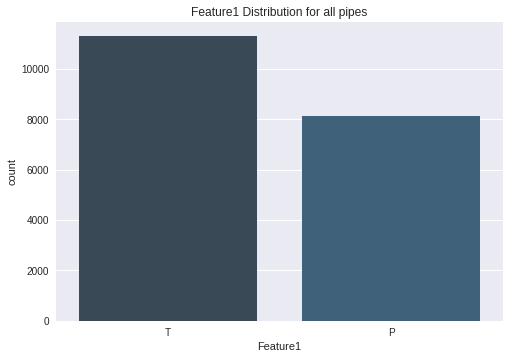

In [28]:
#Feature 1:

sns.countplot(data["Feature1"],palette=sns.color_palette("Blues_d")).set_title("Feature1 Distribution for all pipes")
plt.show()

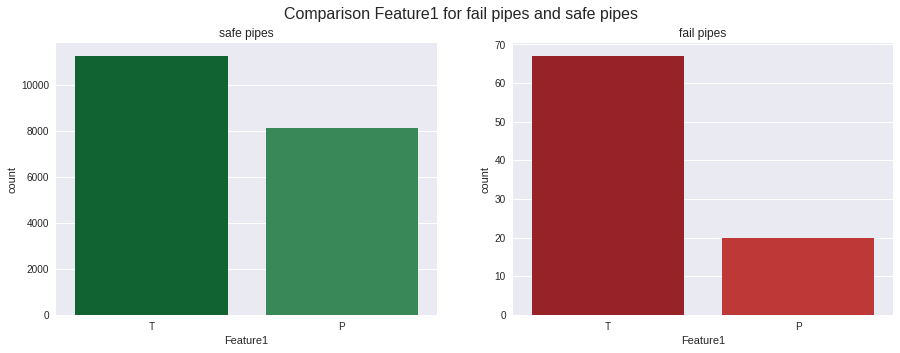

In [29]:
fig, ax=plt.subplots(1,2,figsize=(15,5))
sns.countplot(data["Feature1"].loc[index_safe],ax=ax[0],palette=sns.color_palette("BuGn_r"))
sns.countplot(data["Feature1"].loc[index_fail],ax=ax[1],palette=sns.color_palette("Reds_r"))

fig.suptitle("Comparison Feature1 for fail pipes and safe pipes", fontsize=16)
ax[0].set_title("safe pipes")
ax[1].set_title("fail pipes")
plt.show()

Kind of hard to deduce anything here... It seems like P is less represented for pipe that will fail, but not enough data to conclude anything.

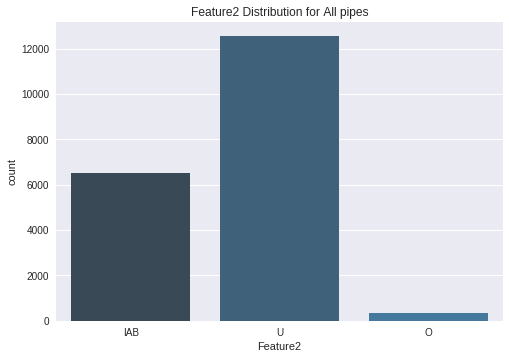

In [30]:
#Feature 2:
sns.countplot(data["Feature2"],palette=sns.color_palette("Blues_d")).set_title("Feature2 Distribution for All pipes")
plt.show()

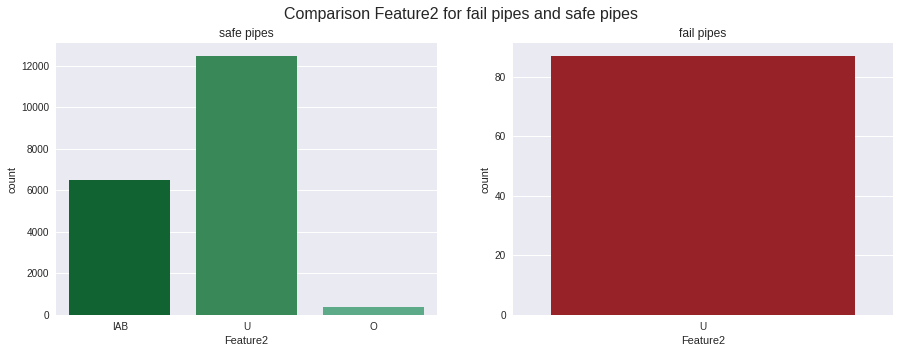

In [31]:
fig, ax=plt.subplots(1,2,figsize=(15,5))
sns.countplot(data["Feature2"].loc[index_safe],ax=ax[0],palette=sns.color_palette("BuGn_r"))
sns.countplot(data["Feature2"].loc[index_fail],ax=ax[1],palette=sns.color_palette("Reds_r"))

fig.suptitle("Comparison Feature2 for fail pipes and safe pipes", fontsize=16)
ax[0].set_title("safe pipes")
ax[1].set_title("fail pipes")
plt.show()

Pipes that will fail only have U as Feature2, its the most represented in normal pipes too but it remains interesting. Can we find this pattern on pipes that already failed once before 2014 ?

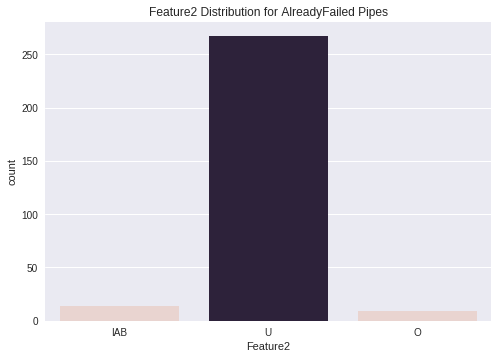

In [32]:
sns.countplot(data.dropna()["Feature2"],palette=sns.cubehelix_palette(2)).set_title("Feature2 Distribution for AlreadyFailed Pipes")
plt.show()

Feature U is majoritary for pipes that will break or that already broke.

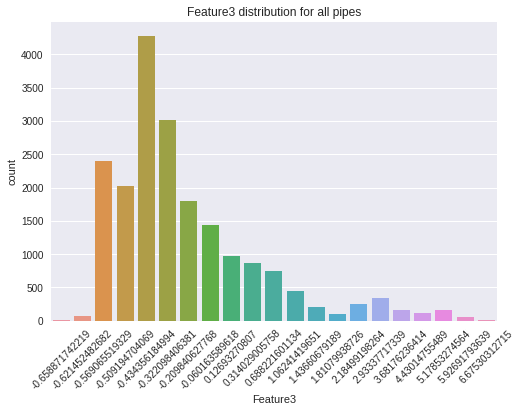

In [34]:
#Feature 3:
sns.countplot(data["Feature3"]).set_title("Feature3 distribution for all pipes")
plt.xticks(rotation=45)
plt.show()

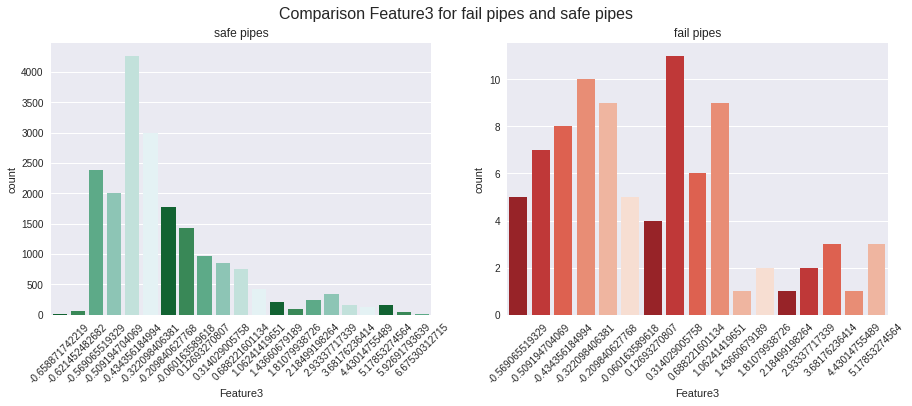

In [27]:
fig, ax=plt.subplots(1,2,figsize=(15,5))
sns.countplot(data["Feature3"].loc[index_safe],ax=ax[0],palette=sns.color_palette("BuGn_r"))
sns.countplot(data["Feature3"].loc[index_fail],ax=ax[1],palette=sns.color_palette("Reds_r"))

fig.suptitle("Comparison Feature3 for fail pipes and safe pipes", fontsize=16)
ax[0].set_title("safe pipes")
ax[1].set_title("fail pipes")

#rotation labels:
for ax in ax:
    plt.sca(ax)
    plt.xticks(rotation=45)
    
plt.show()

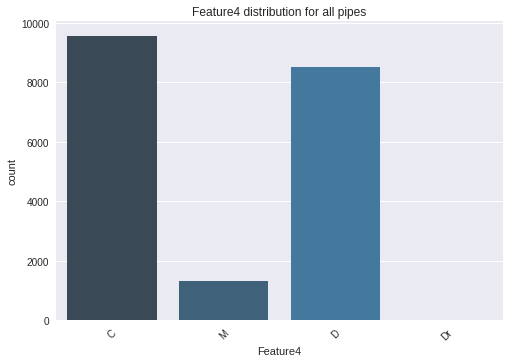

In [28]:
#Feature 4:
sns.countplot(data["Feature4"],palette=sns.color_palette("Blues_d")).set_title("Feature4 distribution for all pipes")
plt.xticks(rotation=45)
plt.show()

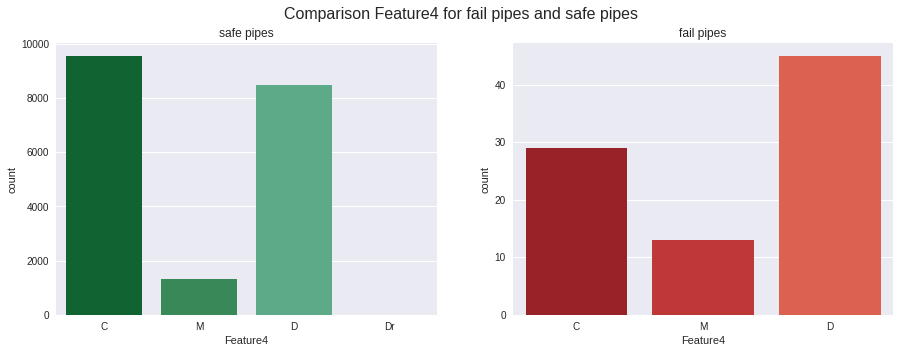

In [29]:
fig, ax=plt.subplots(1,2,figsize=(15,5))
sns.countplot(data["Feature4"].loc[index_safe],ax=ax[0],palette=sns.color_palette("BuGn_r"))
sns.countplot(data["Feature4"].loc[index_fail],ax=ax[1],palette=sns.color_palette("Reds_r"))

fig.suptitle("Comparison Feature4 for fail pipes and safe pipes", fontsize=16)
ax[0].set_title("safe pipes")
ax[1].set_title("fail pipes")

    
plt.show()

## Vizualizing some Pairwise Relationship

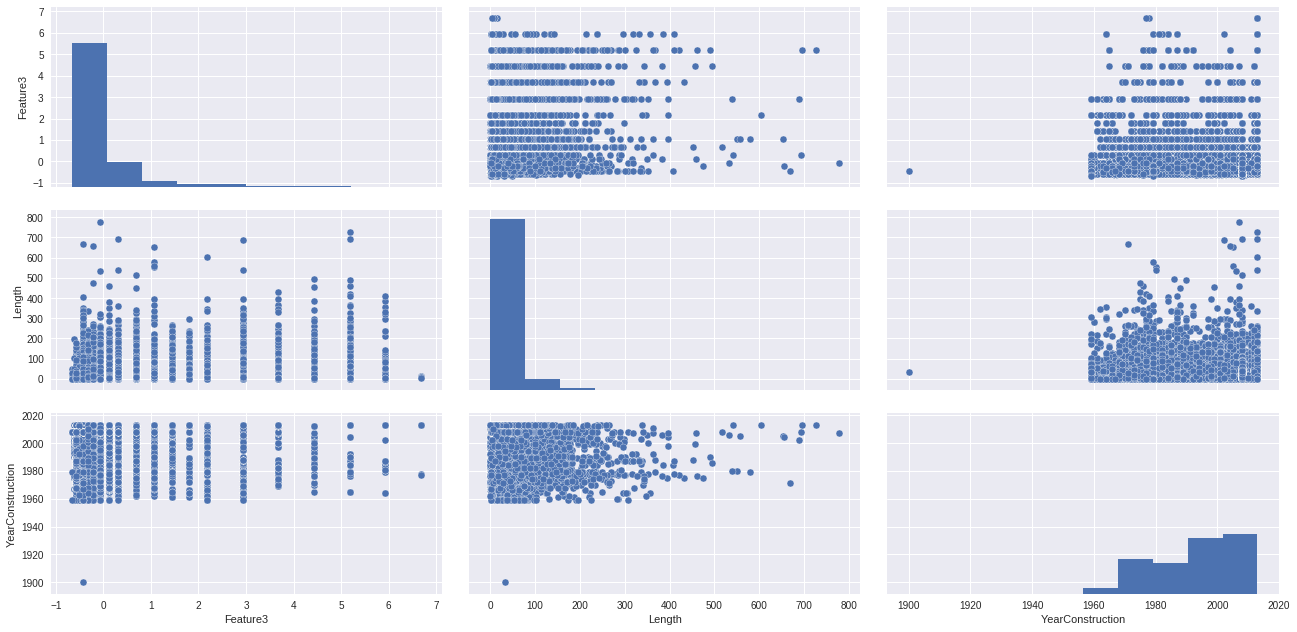

In [45]:
sns.pairplot(data[["Feature3","Length","YearConstruction"]],size=3,aspect=2);
plt.show()

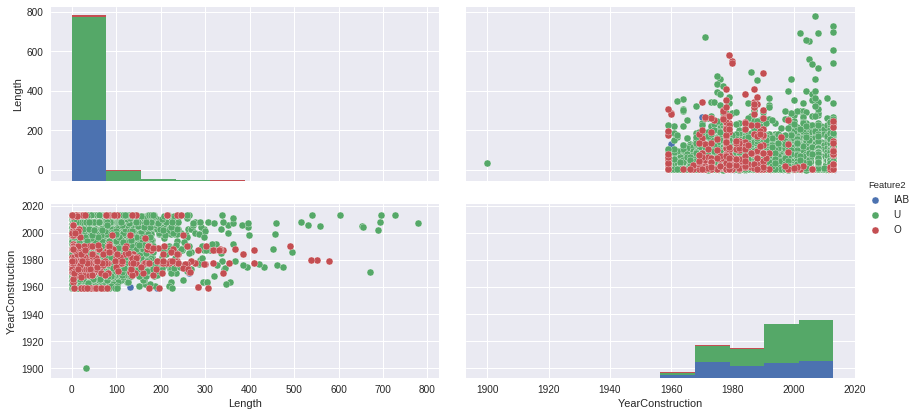

In [46]:
sns.pairplot(data[["Length","YearConstruction","Feature2"]].loc[index_safe],
             hue="Feature2",size=3,aspect=2);
plt.show()

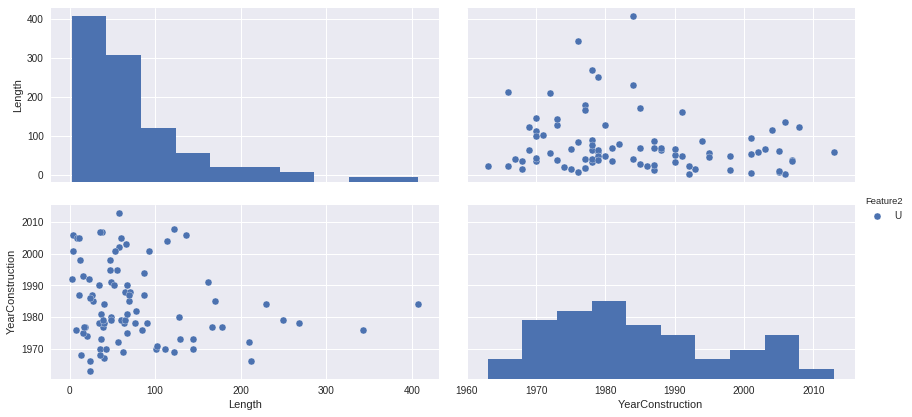

In [47]:
sns.pairplot(data[["Length","YearConstruction","Feature2"]].loc[index_fail],
             hue="Feature2",size=3,aspect=2);
plt.show()

In [48]:
temp=pd.concat([data[["Length","YearConstruction"]],target["2014"]],axis=1)
temp.head(2)

,Length,YearConstruction,2014
0,3.5972,2001,0
1,4.0547,1965,0


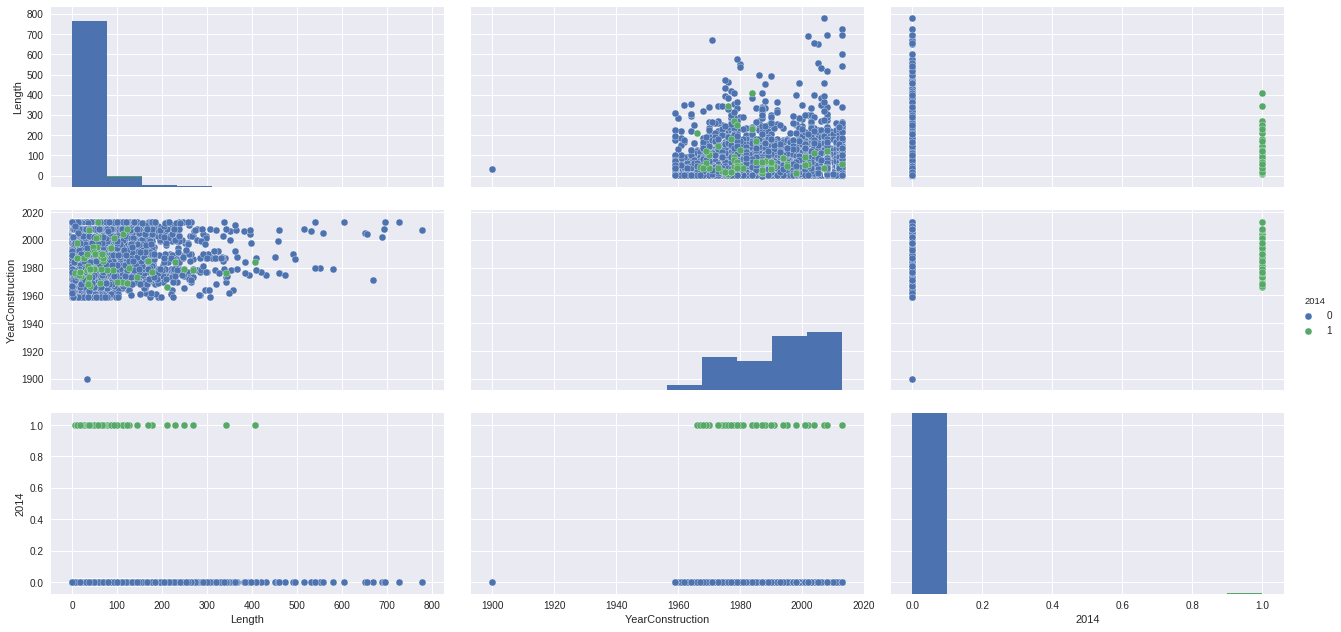

In [49]:
sns.pairplot(temp,hue="2014",size=3,aspect=2);
plt.show()

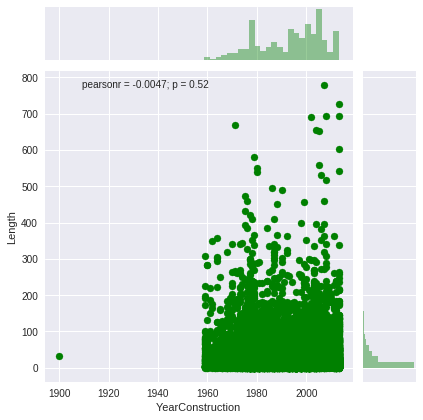

In [108]:
sns.jointplot(x=data["YearConstruction"].loc[index_safe],y=data["Length"].loc[index_safe],color="green")
plt.show()

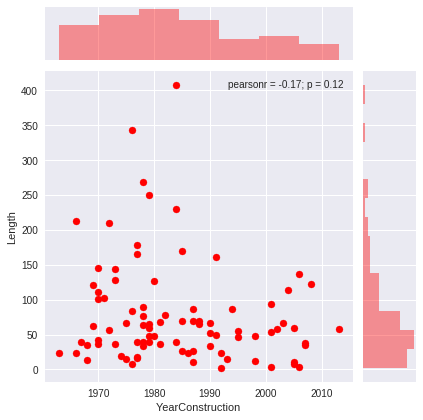

In [50]:
sns.jointplot(x=data["YearConstruction"].loc[index_fail],y=data["Length"].loc[index_fail],color="red")
plt.show()